In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# 犬猫の画像で多クラス分類モデル試す
## <font color="Red">クラスごとに画像ディレクトリ別れてる場合で分類モデル作成<font>

#### 犬猫画像は以下のサイトから取得できた
- https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765


## モジュールimport

In [2]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')

from dataset import plot_log, prepare_data, util

from transformer import tf_get_train_valid_test as get_train_valid_test
from transformer import tf_my_generator as my_generator

from model import tf_define_model as define_model
from model import tf_multi_loss as multi_loss
from model import tf_my_callback as my_callback
from model import my_metric

from predicter import roc_curve, conf_matrix, ensemble_predict
from predicter import tf_grad_cam as grad_cam
from predicter import tf_base_predict as  base_predict

#import pathlib
#current_dir = pathlib.Path("__file__").resolve().parent
#sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\Git\keras-squeeze-excite-network')
#import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

from tensorflow import keras

import glob, time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pathlib

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

## 画像をtrain/validation/test set に分ける
- train_count=500*2
- valid_count=200*2
- test_count=100*2

import os, shutil, glob
from tqdm import tqdm

def split_class_train_valid_test_set(class_name_list, source_dir, img_dir
                                     , train_count=500, valid_count=200, test_count=100):
    """
    クラスディレクトリごとに別れた指定ディレクトリの画像を tarin/val set に分けてコピーする
    クラスごとの画像枚数の指定（train_count, valid_count, test_count）がなければ train:0.7, valid:0.2, test:0.1 の割合でコピー
    """

    print('source_dir :', source_dir)
    print('img_dir :', img_dir)
    print('---------------------------------------------------------------')
    for class_name in class_name_list:
        print('class_name :', class_name)
        # クラスごとの画像総数
        class_source_dir = os.path.join(source_dir, class_name)
        # ファイル名一応ソートしておく
        id_imgs = sorted(glob.glob(os.path.join(class_source_dir, '*jpg')))
        print('imgs:', len(id_imgs))

        # 画像ディレクトリ作成
        train_dir = os.path.join(img_dir, 'train', class_name)
        valid_dir = os.path.join(img_dir, 'validation', class_name)
        test_dir = os.path.join(img_dir, 'test', class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(valid_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        # train/validation/test set に分ける画像枚数していなければ 7:2:1 で分ける
        if train_count is None:
            test_count =  int(len(id_imgs)*0.1)
            valid_count = int(len(id_imgs)*0.2)
            train_count = len(id_imgs) - valid_count - test_count

        # test img copy
        for img in tqdm(id_imgs[0: test_count]):
            shutil.copyfile(img, os.path.join(test_dir, os.path.basename(img)))
        # validation img copy
        for img in tqdm(id_imgs[test_count: valid_count+test_count]):
            shutil.copyfile(img, os.path.join(valid_dir, os.path.basename(img)))
        # train img copy
        for img in tqdm(id_imgs[valid_count+test_count: train_count+valid_count+test_count]):
            shutil.copyfile(img, os.path.join(train_dir, os.path.basename(img)))


# クラス名のリスト
class_name = ['Cat', 'Dog']

# cat, dog 全画像格納しているディレクトリ
source_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\kagglecatsanddogs_3367a\PetImages'

# train/validation/test set に分ける画像ディレクトリ
img_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set'

train_1class_count = 500 # train 1クラスの画像枚数
valid_1class_count = 200 # validaiton 1クラスの画像枚数
test_1class_count = 100  # test 1クラスの画像枚数

# クラスディレクトリごとに別れた指定ディレクトリの画像を tarin/val set に分けてコピーする
split_class_train_valid_test_set(class_name, source_dir, img_dir
                                 , train_count=train_1class_count
                                 , valid_count=valid_1class_count
                                 , test_count=test_1class_count
                                )

## パラメータ設定

In [3]:
import os, sys, glob, time

# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\tf_Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py'
os.makedirs(output_dir, exist_ok=True)

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = util.file_count(train_data_dir, r'.jpg')

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = util.file_count(validation_data_dir, r'.jpg')

# テスト画像ディレクトリ
test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

# 入力層のサイズ
#img_rows, img_cols, channels=331, 331, 3
img_rows, img_cols, channels=100, 100, 3

# 分類クラス
class_name = ['Cat', 'Dog']
classes = class_name#['0', '1']
nb_classes = len(classes)
activation='softmax'

# GradCamで切り出す層名
layer_name = 'multiply_1'

# ハイパーパラメータ
num_epoch=5#10
batch_size=10
val_batch_size=10
test_batch_size=10

# optimizer のパラメータ
choice_optim='sgd'
lr=0.1 * batch_size / 128
#decay=1e-3
momentum=0.9

# fine-tuningモデル
choice_model='InceptionResNetV2'
trainable=761

# 全結合層
FCnum=1

# 学習打ち切りオプション
early_stopping=10

plateau_pati=5
plateau_factor=0.5 # コールバックが起動したら学習率0.9倍
plateau_monitor='val_loss'

# https://qiita.com/ak11/items/67118e11b756b0ee83a5
base_lr = lr #0.1 * batch_size / 128  # adamとかなら1e-3くらい。SGDなら例えば 0.1 * batch_size / 128 とかくらい。nadamなら0.002*10 ?
lr_decay_rate = 1/2#1 / 3
lr_steps = 2#4

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
vertical_flip=True
zoom_range=0.2
rotation_range=20
channel_shift_range=5.
brightness_range=[0.3, 1.0]
# custom param
mix_up_alpha=0.2# mixup alpha
#random_crop=[224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255
ricap_beta=0.3 # RICAP beta
ricap_use_same_random_value_on_batch=True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
is_base_aug=True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
             , 'vertical_flip': vertical_flip
             , 'zoom_range': zoom_range
             , 'rotation_range': rotation_range 
             , 'channel_shift_range': channel_shift_range
             , 'brightness_range': brightness_range
             , 'mix_up_alpha': mix_up_alpha
             , 'random_erasing_prob': random_erasing_prob
             , 'random_erasing_maxpixel': random_erasing_maxpixel
             , 'ricap_beta': ricap_beta
             , 'ricap_use_same_random_value_on_batch': ricap_use_same_random_value_on_batch
             #, 'is_base_aug': is_base_aug
            }

## data generator定義
- データ管理クラス：d_cls

In [4]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=val_batch_size
                                            , test_batch_size=test_batch_size)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options
                                              , is_valid_grayscale=False # validation generatorをグレースケール化するか
                                             )

my_IDG_options: {'rescale': 0.00392156862745098, 'vertical_flip': True, 'zoom_range': 0.2, 'rotation_range': 20, 'channel_shift_range': 5.0, 'brightness_range': [0.3, 1.0], 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x000001DF12E76A48>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x1df03966548>)

Found 1000 images belonging to 2 classes.
(10, 100, 100, 3)
[[[0.22130454 0.20802543 0.21987894]
  [0.21194699 0.19866788 0.20909579]
  [0.20294468 0.19225034 0.20383743]
  ...
  [0.39807462 0.43331943 0.43073792]
  [0.38002555 0.41317556 0.40849926]
  [0.3484343  0.37529994 0.37245042]]

 [[0.22522611 0.2106102  0.22112692]
  [0.21987894 0.20659982 0.21836453]
  [0.2147982  0.20410386 0.21444296]
  ...
  [0.34334206 0.37439728 0.37391057]
  [0.34495013 0.37600536 0.37525063]
  [0.32227406 0.35150252 0.35074779]]

 [[0.21845334 0.20392624 0.20900698]
  [0.21854215 0.20526303 0.21426534]
  [0.22130454 0.2106102  0.22353408]
  ...
  [0.28522394 0.31208959 0.30112892]
  [0.28946283 0.3145017  0.30536781]
  [0.2563128  0.2816197  0.27248581]]

 ...

 [[0.21433374 0.11709941 0.0801955 ]
  [0.19866461 0.10769793 0.07079403]
  [0.18691705 0.10613959 0.07236951]
  ...
  [0.18340732 0.14639025 0.09164685]
  [0.19963795 0.15971935 0.10615453]
  [0.21935941 0.20469317 0.12936683]]

 [[0.22686903 

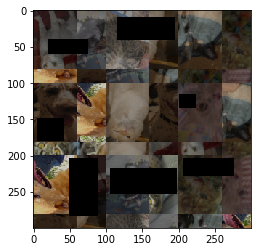

In [5]:
def print_gen(gen, i=0):
    x,y = next(gen)
    print(x.shape)
    print(x[i])
    print(np.max(x))
    print(y.shape)
    print(y[i])
    util.show_tile_img(x)
    #for ii in range(len(y)):
    #    plt.imshow(x[ii])
    #    plt.show()

print_gen(d_cls.train_gen, i=5)

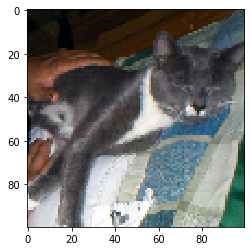

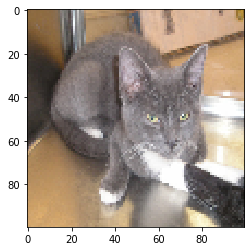

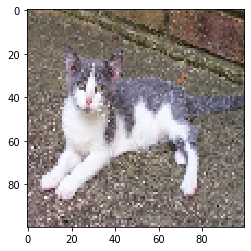

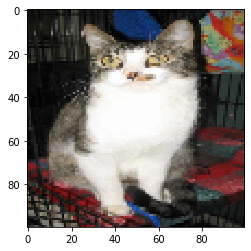

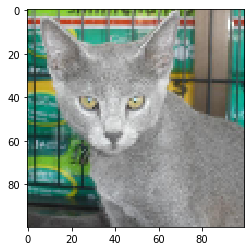

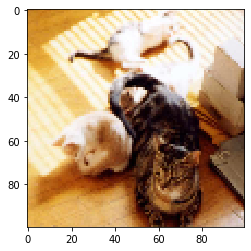

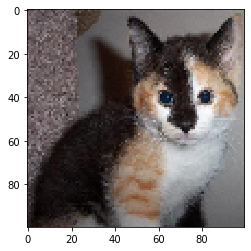

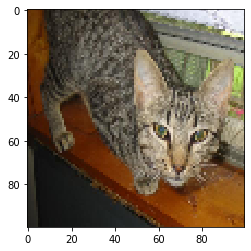

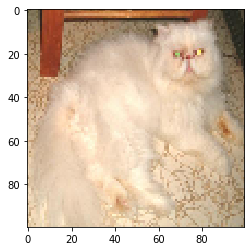

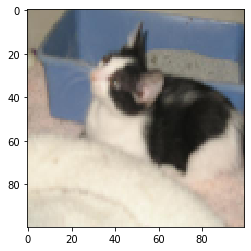

In [6]:
def print_gen(gen, i=0):
    x,y = next(gen)
    for ii in range(len(y)):
        plt.imshow(x[ii])
        plt.show()

print_gen(d_cls.valid_gen, i=10)

## ニューラルネットワーク定義

- InceptionResNetV2+attension
- 761層以前をfreeze(ただし、Batch Normalizationはfreeze解除)

In [7]:
# モデル定義
model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels, nb_classes
                                                       , choice_model, trainable
                                                       #, fcpool='attention'
                                                       , activation=activation
                                                      )
# compile the model
optim = define_model.get_optimizers(choice_optim=choice_optim, lr=lr, momentum=momentum, nesterov=True)#, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)
model.compile(loss='categorical_crossentropy'
              , optimizer=optim
              , metrics=['accuracy'])
              #, metrics=['accuracy', lr_metric])

# finetunning用にレイヤーの数と名前を表示
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1
#keras.utils.plot_model(model, to_file=os.path.join(output_dir, 'InceptionResNetV2_attention.svg'), show_shapes=True)

----- model_param -----
output_dir = D:\work\kaggle_data\tf_Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = InceptionResNetV2 761
fcs = []
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0078125 0.9 0.0 True
0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d

In [8]:
define_model.print_model_summary(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

block17_17_conv (Conv2D)        (None, 4, 4, 1088)   418880      block17_17_mixed[0][0]           
__________________________________________________________________________________________________
block17_17 (Lambda)             (None, 4, 4, 1088)   0           block17_16_ac[0][0]              
                                                                 block17_17_conv[0][0]            
__________________________________________________________________________________________________
block17_17_ac (Activation)      (None, 4, 4, 1088)   0           block17_17[0][0]                 
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 4, 4, 128)    139264      block17_17_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 4, 4, 128)    384         conv2d_145[0][0]                 
__________

35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed_5b False
41 conv2d_15 False
42 batch_normalization_15 False
43 activation_15 False
44 conv2d_13 False
45 conv2d_16 False
46 batch_normalization_13 False
47 batch_normalization_16 False
48 activation_13 False
49 activation_16 False
50 conv2d_12 False
51 conv2d_14 False
52 conv2d_17 False
53 batch_normalization_12 False
54 batch_normalization_14 False
55 batch_normalization_17 False
56 activation_12 False
57 activation_14 False
58 activation_17 False
59 block35_1_mixed False
60 block35_1_conv False
    weights.shape:(1, 1, 128, 320)
61 block35_1 False
62 block35_1_ac False
63 conv2d_21 False
64 batch_normalization_21 False
65 activation_21 False
66 conv2d_19 False
67 conv2d_22 False
68 batch_normalization_19 False
69 batch_normalization_22 False
70 activation_19 False
71 activation_22 False
72 conv2d_18 False
73 conv2d_20 False
74 conv2d_23 False
75 batch_nor

356 batch_normalization_97 False
357 activation_97 False
358 conv2d_98 False
359 batch_normalization_98 False
360 activation_98 False
361 conv2d_96 False
362 conv2d_99 False
363 batch_normalization_96 False
364 batch_normalization_99 False
365 activation_96 False
366 activation_99 False
367 block17_6_mixed False
368 block17_6_conv False
    weights.shape:(1, 1, 384, 1088)
369 block17_6 False
370 block17_6_ac False
371 conv2d_101 False
372 batch_normalization_101 False
373 activation_101 False
374 conv2d_102 False
375 batch_normalization_102 False
376 activation_102 False
377 conv2d_100 False
378 conv2d_103 False
379 batch_normalization_100 False
380 batch_normalization_103 False
381 activation_100 False
382 activation_103 False
383 block17_7_mixed False
384 block17_7_conv False
    weights.shape:(1, 1, 384, 1088)
385 block17_7 False
386 block17_7_ac False
387 conv2d_105 False
388 batch_normalization_105 False
389 activation_105 False
390 conv2d_106 False
391 batch_normalization_106 Fal

667 batch_normalization_176 False
668 activation_176 False
669 conv2d_177 False
670 batch_normalization_177 False
671 activation_177 False
672 conv2d_175 False
673 conv2d_178 False
674 batch_normalization_175 False
675 batch_normalization_178 False
676 activation_175 False
677 activation_178 False
678 block8_4_mixed False
679 block8_4_conv False
    weights.shape:(1, 1, 448, 2080)
680 block8_4 False
681 block8_4_ac False
682 conv2d_180 False
683 batch_normalization_180 False
684 activation_180 False
685 conv2d_181 False
686 batch_normalization_181 False
687 activation_181 False
688 conv2d_179 False
689 conv2d_182 False
690 batch_normalization_179 False
691 batch_normalization_182 False
692 activation_179 False
693 activation_182 False
694 block8_5_mixed False
695 block8_5_conv False
    weights.shape:(1, 1, 448, 2080)
696 block8_5 False
697 block8_5_ac False
698 conv2d_184 False
699 batch_normalization_184 False
700 activation_184 False
701 conv2d_185 False
702 batch_normalization_185 

## callback

In [14]:
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(epochs=num_epoch))

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    #checkpoint_path = os.path.join(output_dir, "training_1/cp.ckpt")
    #checkpoint_dir = os.path.dirname(checkpoint_path)
    #cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping, verbose=1))
    
    return cb

## 学習実行

In [15]:
%%time
start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen,
    steps_per_epoch = train_samples//batch_size,# 1エポックあたりの学習(step)回数
    epochs = num_epoch,# エポック数
    validation_data = d_cls.valid_gen,# 検証ファイル生成
    validation_steps = val_samples//val_batch_size,# 検証するファイル数
    verbose = 1,# 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    callbacks = get_cb(output_dir, cosine_annealing_num_epoch=None)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

Epoch 1/5
 99/100 [============================>.] - ETA: 0s - loss: 0.7626 - accuracy: 0.5576

AttributeError: 'DirectoryIterator' object has no attribute 'shape'

## 学習曲線

In [ ]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'))

## valid,test setのloss,acc評価

In [ ]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

In [ ]:
# val_batch_size, test_batch_size の枚数だけevaluate
scoreSeg = model.evaluate_generator(d_cls.valid_gen, val_batch_size)
print("val_loss = ",scoreSeg[0])
print("val_acc = ",scoreSeg[1])

scoreSeg = model.evaluate_generator(d_cls.test_gen, test_batch_size)
print("\ntest_loss = ",scoreSeg[0])
print("test_acc = ",scoreSeg[1])

In [ ]:
# evaluate_generator はflow_from_directory でラベルクラスが親ディレクトリである場合しか使えない評価関数（lossとaccを出す）
# なので、基本train/validation setにしか使えない（test setは正解ラベルないケースが普通なので）

# evaluate_generator はgenerator だけ引数に渡したら全件予測してくれるみたい
# ただし、batch size ごとに予測するから総数/batch_size が割り切れる数になっていないと、あまりの分が2回predictされてしまう
# 安全な方法はbatch_size=1 にしたgenerator で実行（複数一気にpredictしないから時間かかる）
# https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
scoreSeg = model.evaluate_generator(d_cls.valid_gen, steps=len(d_cls.valid_gen))
print("val_loss = ",scoreSeg[0])
print("val_acc = ",scoreSeg[1])

scoreSeg = model.evaluate_generator(d_cls.test_gen, steps=len(d_cls.test_gen))
print("\ntest_loss = ",scoreSeg[0])
print("test_acc = ",scoreSeg[1])

## predict+混同行列

In [ ]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

In [ ]:
# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
pred_df.head()

In [ ]:
# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir)

## 1件ずつ予測+GradCam

In [ ]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

In [ ]:
from keras.preprocessing import image

# 入力画像のファイルパス
data_paths = glob.glob(train_data_dir+'/**', recursive=True)
pred_path = data_paths[3]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'multiply_1', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

### K.set_learning_phase 指定無しのGradCamとK.set_learning_phase(0) のGradCamは同じ結果になる 

In [ ]:
from keras.preprocessing import image

import keras.backend as K
K.clear_session()
K.set_learning_phase(0)

#load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

# 入力画像のファイルパス
data_paths = glob.glob(train_data_dir+'/**', recursive=True)
pred_path = data_paths[3]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'activation_162', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

### 他の画像でもGradCam実行

In [ ]:
import keras.backend as K
K.clear_session()
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

In [ ]:
from keras.preprocessing import image

data_paths = glob.glob(validation_data_dir+'/**', recursive=True)
pred_path = data_paths[100]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'multiply_1', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

In [ ]:
from keras.preprocessing import image

data_paths = glob.glob(test_dir+'/**', recursive=True)
pred_path = data_paths[13]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'multiply_1', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

# --------------------------------------------------------------------------------------------

# Optunaで学習実行

In [1]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric, my_class_weight
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict
from tuning import optuna_train_base, optuna_train_Tox21, optuna_util

sys.path.append(r'C:\Users\shingo\Git\keras-squeeze-excite-network')
import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

import keras
import optuna
import numpy as np
import shutil
%matplotlib inline

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = util.file_count(train_data_dir, r'.jpg')

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = util.file_count(validation_data_dir, r'.jpg')

# 画像管理クラス
d_cls=get_train_valid_test.LabeledDataset([100, 100, 3]
                                          , 10
                                          , valid_batch_size=10
                                          , test_batch_size=10
                                          , train_samples = train_samples
                                          , valid_samples = val_samples
                                         )

# 基本コールバック
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1))
    
    return cb

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v4\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ndimage.py: loaded as module file
my_generator.py: loaded as module file
get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
my_class_weight.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file
base_predict.py: loaded as module file
optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file
optuna_util.py: loaded as module file
train_steps_per_epoch : 100
valid_steps_per_epoch : 40


### 目的関数の定義
#### チューニング可能パラメータ
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル
    - fine-tuning
    - 全結合0-5層（重みの初期値はhe_normal(He の正規分布)で固定）
        - ユニット数 (同じ値か層ごとに減らす)
        - dropout_rate (全層同じ値になる)
        - Batch_Normalization (全層同じ値になる)
        - l2正則化(weight decay) (全層同じ値になる)
- オプティマイザ
- 学習率
    - 学習率変更なし
    - cosine_annealing(factor=0.01, epochs=None)
    - LearningRateScheduler(lr* 1/4 を3回する)
- データ水増し( keras.preprocessing.image.ImageDataGenerator )
    - 画像の剪断(shear)
    - 拡大縮小(zoom)
    - 回転(rotation)
    - 上下反転(vertical_flip)
    - 左右反転(horizontal_flip)
    - ランダムに画素値に値を足す（channel_shift_range）
    - ランダムに明度を変更（brightness_range）
    - 画像ランダムに切り取り（random_crop）
    - 画像の一部矩形領域を隠す（random_erasing)
    - 画像混ぜる(mix_up)

In [2]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna'
os.makedirs(output_dir, exist_ok=True)

# Trueならbest_parameter をval_loss でとる。Falseならval_accでとる
return_val_loss=True#False

# Optunaでの枝刈り入れるか True ならval_lossで枝刈り
prune=True 

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['VGG16', 'Xception']#['PeleeNet']#['SEInceptionV3']#['Xception','InceptionResNetV2','NASNetLarge']# 学習済みモデル
trainable = ['all']#[116, 761, 1017, 'all'] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
decay=[0.0] # モデルのオプティマイザのdecay
FCnum = [0,1,2]#[1]#[0,1,2] # FC層の数
Dence = [512, 256, 128] # FC層のユニット数
Dropout = [0.0, 0.5] # FC層のDropout
kernel_initializer=['he_normal'] # FC層の重みの初期値
addBatchNorm = [None] # FC層のBatchNorm
l2 = [0.0, 5e-4] # FC層のl2
choice_optim = ['sgd', 'adam', 'nadam', 'adabound'] # optimizer
adam_amsgrad = [False, True] # Adam で学習率に過去の勾配の勾配の影響をゆっくりと減衰させるAMSGrad 含めるか。keras2.1.5以上から使える。keras.optimizers.Adam()のでデフォルトはFalse
lr = [1.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # （初期）学習率
callback_lr = [None, 'cosine_annealing'] # 学習率変更するcallback
callback_save_model=False#True # モデル保存するcallback つけるか. False なら保存しない

if callback_save_model == True:
    model_dir = os.path.join(output_dir, 'model_weight_optuna')

# クラスの不均衡を考慮して、トレーニングデータのclass_weight
class_name = ['Cat', 'Dog']
class_weight = my_class_weight.cal_weight(class_name, train_data_dir)
    
## ImageDataGenerator param
rescale=1.0/255.0 # 画像の前処理
horizontal_flip=[True]#[True, False]#[False] # 画像の左右反転
vertical_flip=[False]#[True, False]#[False] # 画像の上下反転
# 画像の回転の下限角、回転の上限角、回転角の刻み幅
rotation_range_min=0#-30 
rotation_range_max=30#30#0#180
rotation_unit=0.0# 0.0 にしたら rotation_range_max で固定
# 画像の縮小の最少-最大倍率、拡大の最少-最大倍率、縮小拡大倍率の刻み幅
zoom_range_low_min=0.1#1.0#0.5
zoom_range_low_max=1.0#1.0
zoom_range_high_min=1.0#1.0
zoom_range_high_max=1.9#1.0#1.5
zoom_range_unit=0.0#0.1 # 0.0 にしたら zoom_range_low_min, zoom_range_high_max で固定
# 画像のせん断の最少倍率、せん断の最大倍率、せん断倍率の刻み幅
shear_range_min=-0.0#0.0
shear_range_max=0.0#0.0#0.5
shear_range_unit=0.0#0.1 # 0.0 にしたら shear_range_max で固定
# ランダムに画素値に値を足す
channel_shift_range_min=-0.0#0.0
channel_shift_range_max=0.0#0.0#10.0
channel_shift_range_unit=0.0#0.1 # 0.0 にしたら channel_shift_range_max で固定
# ランダムに明度を変更 brightness_range=[0.3, 1.0]みたいなの
brightness_range_low_min=1.0#0.3
brightness_range_low_max=1.0
brightness_range_high_min=1.0
brightness_range_high_max=1.0#1.3
brightness_range_unit=0.0 # 0.0 ならランダムに明度変更倍率は固定値(self.brightness_range_low_min, self.brightness_range_high_max)
# 画像のrandom_crop.付ける場合は[224,224]とかにする
random_crop=None 
# random_erasing の確率. 使わない場合は0.0にする
random_erasing_prob=[0.5]#[0.0, 0.5] 
# random_erasing で消す領域の画素の最大値
random_erasing_maxpixel=255.0 
# mixup 含めるか
mix_up_alpha=[0.0, 0.2] 
# RICAP 含めるか
ricap_beta=[0.0, 0.3] 
ricap_use_same_random_value_on_batch=[True] # RICAP Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train_base.Objective(out_dir=output_dir
                                        , d_cls=d_cls
                                        , train_data_dir=train_data_dir
                                        , validation_data_dir=validation_data_dir
                                        , shape=[100, 100, 3]
                                        , num_classes=len(class_name)
                                        , class_name=class_name
                                        , epochs=2
                                        , gpu_count=1
                                        , loss='categorical_crossentropy'
                                        , metrics=['acc']
                                        , verbose=2
                                        , activation='softmax'
                                        , pred_kernel_initializer='zeros'
                                        , pred_l2_rate=0.0001
                                        , FCpool=['GlobalAveragePooling2D']
                                        , return_val_loss=return_val_loss
                                        , callbacks=get_cb(output_dir, cosine_annealing_num_epoch=None)
                                        , callback_save_model=callback_save_model
                                        , choice_model=choice_model
                                        , trainable=trainable
                                        , decay=decay
                                        , FCnum=FCnum
                                        , Dence=Dence
                                        , Dropout=Dropout
                                        , addBatchNorm=addBatchNorm
                                        , kernel_initializer=kernel_initializer
                                        , l2=l2
                                        , choice_optim=choice_optim
                                        , adam_amsgrad=adam_amsgrad
                                        , lr=lr
                                        , callback_lr=callback_lr
                                        , class_weight=class_weight
                                        , rescale=rescale
                                        , horizontal_flip=horizontal_flip
                                        , vertical_flip=vertical_flip
                                        , rotation_range_min=rotation_range_min
                                        , rotation_range_max=rotation_range_max
                                        , rotation_unit=rotation_unit
                                        , zoom_range_low_min=zoom_range_low_min
                                        , zoom_range_low_max=zoom_range_low_max
                                        , zoom_range_high_min=zoom_range_high_min
                                        , zoom_range_high_max=zoom_range_high_max
                                        , zoom_range_unit=zoom_range_unit
                                        , shear_range_min=shear_range_min
                                        , shear_range_max=shear_range_max
                                        , shear_range_unit=shear_range_unit
                                        , channel_shift_range_min=channel_shift_range_min
                                        , channel_shift_range_max=channel_shift_range_max
                                        , channel_shift_range_unit=channel_shift_range_unit
                                        , brightness_range_low_min=brightness_range_low_min
                                        , brightness_range_low_max=brightness_range_low_max
                                        , brightness_range_high_min=brightness_range_high_min
                                        , brightness_range_high_max=brightness_range_high_max
                                        , brightness_range_unit=brightness_range_unit
                                        , random_crop=random_crop 
                                        , random_erasing_prob=random_erasing_prob
                                        , random_erasing_maxpixel=random_erasing_maxpixel
                                        , mix_up_alpha=mix_up_alpha
                                        , ricap_beta=ricap_beta
                                        , ricap_use_same_random_value_on_batch=ricap_use_same_random_value_on_batch
                                       )

### 最適化の実行

In [3]:
%%time
# sqlite 使って履歴ファイル作る
sqllite_path = output_dir+'/example.db'
if os.path.exists(sqllite_path) == True:
    os.remove(sqllite_path) # sqllite_pathすでにあれば一旦削除
study = optuna.create_study(study_name='example-study', storage='sqlite:///'+sqllite_path)

study.optimize(objective, n_trials=2)

[I 2019-09-25 00:38:08,687] A new study created with name: example-study


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 all
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v4\lib\site-packages\keras\engine\saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



----- FC_layer -----
---- choice_optim = adam ----
adam_lr adam_decay beta_1 beta_2 = 0.001 0.0 0.9 0.999
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 30, 'zoom_range': [0.1, 1.9], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255.0, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'is_base_aug': False}
Found 400 images belonging to 2 classes.
callback: [<model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x000001FB0B2CF780>, <model.my_callback.learning_curve_plot.<locals>._LearningCurvePlotter object at 0x000001FB1C2BDEF0>, <keras.callbacks.ModelCheckpoint object at 0x000001FB1C2BDF60>, <keras.callbacks.EarlyStopping object at 0x000001FB1C2BD860>, <keras.callbacks.ModelCheckpoint object at 0x000001FB40CC29B0>, <keras.callbacks.ModelCheckpoint object at 0x000001FB

C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\model\my_callback.py:159: MatplotlibDeprecationWarning:


The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.




Epoch 00002: val_loss improved from 0.69313 to 0.69311, saving model to D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna\finetuning.h5
check_loss, self.trial_best_loss: 0.693113824725151 1000.0
check_metrics, self.trial_best_metrics: 0.5 1000.0


[I 2019-09-25 00:38:55,776] Finished trial#0 resulted in value: 0.693113824725151. Current best value is 0.693113824725151 with parameters: {'FCnum': 0, 'FCpool': 'GlobalAveragePooling2D', 'adam_amsgrad': False, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'decay': 0.0, 'efficientnet_num': 3, 'horizontal_flip': True, 'is_base_aug': False, 'lr': 0.001, 'mix_up_alpha': 0.2, 'oct_conv_alpha': 0.25, 'random_erasing_prob': 0.5, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 'all', 'vertical_flip': False, 'wrn_N': 4, 'wrn_k': 10}.


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 all
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = adabound ----
adabound_lr adabound_final_lr adabound_decay beta_1 beta_2, amsbound = 1.0 10.0 0.0 0.9 0.999 True
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 30, 'zoom_range': [0.1, 1.9], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.0, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255.0, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'is_base_aug': False}
Found 400 images belonging to 2 classes.
callback: [<model.

[I 2019-09-25 00:39:35,321] Finished trial#1 resulted in value: 8.063766128616408. Current best value is 0.693113824725151 with parameters: {'FCnum': 0, 'FCpool': 'GlobalAveragePooling2D', 'adam_amsgrad': False, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'decay': 0.0, 'efficientnet_num': 3, 'horizontal_flip': True, 'is_base_aug': False, 'lr': 0.001, 'mix_up_alpha': 0.2, 'oct_conv_alpha': 0.25, 'random_erasing_prob': 0.5, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 'all', 'vertical_flip': False, 'wrn_N': 4, 'wrn_k': 10}.


Wall time: 1min 28s


### 結果の確認

In [4]:
# 試行結果データフレームで出力
study = optuna.Study(study_name='example-study', storage='sqlite:///'+sqllite_path)
df = study.trials_dataframe()
df.to_csv(os.path.join(output_dir, 'optuna_lgb.tsv'), sep='\t')
df

number                state     value             datetime_start  \
                                                                     
0      0  TrialState.COMPLETE  0.693114 2019-09-25 00:38:08.855582   
1      1  TrialState.COMPLETE  8.063766 2019-09-25 00:38:55.780320   

           datetime_complete params                                       \
                              FCnum                  FCpool adam_amsgrad   
0 2019-09-25 00:38:53.891469      0  GlobalAveragePooling2D        False   
1 2019-09-25 00:39:34.198878      0  GlobalAveragePooling2D         True   

                              ...     user_attrs                             \
  add_se branch_Tox21_12task  ... rotation_range          shape shear_range   
0  False               False  ...             30  [100, 100, 3]         0.0   
1  False               False  ...             30  [100, 100, 3]         0.0   

                                                   system_attrs  \
  val_acc  val_loss zoom_range_high zoom_range_low      _number   
0     0.5  0.693114             1.9            0.1            0   
1     0.5  8.063766             1.9            0.1            1   

  intermediate_values            
                    0         1  
0            0.693133  0.693114  
1            8.085871  8.063766  

[2 rows x 55 columns]

In [5]:
# study.best_params ファイル出力
f = open(os.path.join(output_dir, 'best_params.txt'), 'w') # 書き込みモードで開く
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
study.best_params

{'FCnum': 0,
 'FCpool': 'GlobalAveragePooling2D',
 'adam_amsgrad': False,
 'add_se': False,
 'branch_Tox21_12task': False,
 'callback_lr': None,
 'choice_model': 'VGG16',
 'choice_optim': 'adam',
 'decay': 0.0,
 'efficientnet_num': 3,
 'horizontal_flip': True,
 'is_base_aug': False,
 'lr': 0.001,
 'mix_up_alpha': 0.2,
 'oct_conv_alpha': 0.25,
 'random_erasing_prob': 0.5,
 'ricap_beta': 0.0,
 'ricap_use_same_random_value_on_batch': True,
 'sedensenet_num': None,
 'seresnet_num': None,
 'seresnext_num': None,
 'trainable': 'all',
 'vertical_flip': False,
 'wrn_N': 4,
 'wrn_k': 10}

In [6]:
study.best_trial 

FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, value=0.693113824725151, datetime_start=datetime.datetime(2019, 9, 25, 0, 38, 8, 855582), datetime_complete=datetime.datetime(2019, 9, 25, 0, 38, 53, 891469), params={'FCnum': 0, 'FCpool': 'GlobalAveragePooling2D', 'adam_amsgrad': False, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'decay': 0.0, 'efficientnet_num': 3, 'horizontal_flip': True, 'is_base_aug': False, 'lr': 0.001, 'mix_up_alpha': 0.2, 'oct_conv_alpha': 0.25, 'random_erasing_prob': 0.5, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 'all', 'vertical_flip': False, 'wrn_N': 4, 'wrn_k': 10}, user_attrs={'FCpool': "['GlobalAveragePooling2D']", 'acc': 0.5070000069588423, 'activation': 'softmax', 'brightness_range_high': '1.0', 'brightness_range_low': '1.0', 'callbacks': '[<model.my_callback.tsv_logger.<loca

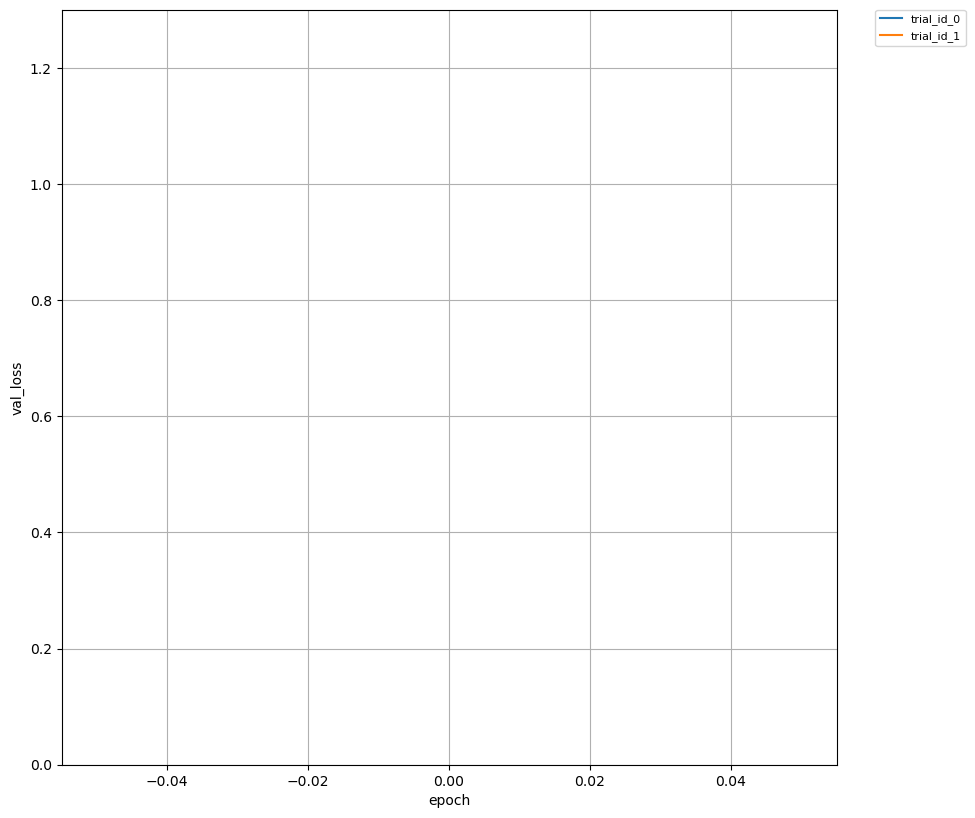

,Unnamed: 0,number,state,value,datetime_start,datetime_complete,params,params.1,params.2,params.3,...,user_attrs.15,user_attrs.16,user_attrs.17,user_attrs.18,user_attrs.19,user_attrs.20,user_attrs.21,system_attrs,intermediate_values,intermediate_values.1
0,NaN,NaN,NaN,NaN,NaN,NaN,FCnum,FCpool,adam_amsgrad,add_se,...,rotation_range,shape,shear_range,val_acc,val_loss,zoom_range_high,zoom_range_low,_number,0.000000,1.000000
1,0.0,0.0,TrialState.COMPLETE,0.693114,2019-09-25 00:38:08.855582,2019-09-25 00:38:53.891469,0,GlobalAveragePooling2D,False,False,...,30,"[100, 100, 3]",0.0,0.5,0.693113824725151,1.9,0.1,0,0.693133,0.693114
2,1.0,1.0,TrialState.COMPLETE,8.063766,2019-09-25 00:38:55.780320,2019-09-25 00:39:34.198878,0,GlobalAveragePooling2D,True,False,...,30,"[100, 100, 3]",0.0,0.5,8.063766128616408,1.9,0.1,1,8.085871,8.063766


<Figure size 432x288 with 0 Axes>

In [7]:
# trial結果ロード
import pandas as pd
result_df = pd.read_table(os.path.join(output_dir, 'optuna_lgb.tsv'))
# optunaのtrial結果plot
optuna_util.trial_plot(output_dir, result_df, epochs=1, val_name="val_loss", trial_id=None)# , trial_id=None # , trial_id=2 # , trial_id=[2,45,46,47,48,49]
result_df
